### Code in the Rscript

In [102]:
install.packages("stringr")
install.packages("data.table")
install.packages("foreach")
install.packages("doParallel")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(dplyr)
library(fuzzyjoin)
library(readxl)
library(IRanges)

library(stringr)
library(tidyr)
library(tibble)

library(data.table)

library(foreach)
library(doParallel)

In [3]:
#OMG - this was really annoying xD
#depending on where one uses data.table (used by GenomicDistributions) one has to consider the local amount of cores..
#https://stackoverflow.com/questions/23107237/r-3-1-0-crashes-with-segfault-when-loading-data-table-package-1-9-2
#apparently the default number of threads is set by data.table to the max number available
#on a system like our work compute server with 128 cores and some packages you are bound to run into memory and address problems

#one can either set global params in bash etc. e.g.: 
#setenv OMP_NUM_THREADS 1

#the other option is to use the openmp utils - https://jangorecki.gitlab.io/data.cube/library/data.table/html/openmp-utils.html,
#to quickly set the number of threads to sth. feasible
data.table::getDTthreads()
data.table::setDTthreads(1)
data.table::getDTthreads()

[1] 128

[1] 1

In [4]:
#samples <- snakemake@params[["samples"]]
#all_types <- snakemake@params[["all_types"]]


samples <- c('Row_01', 'Row_02', 'Row_03', 'Row_04',
          'Row_05', 'Row_06', 'Row_07', 'Row_08',
          'Row_09', 'Row_10', 'Row_11', 'Row_12',
          'Row_13', 'Row_14', 'Row_15', 'Row_16',
          'Row_17', 'Row_18', 'Row_19', 'Row_20',
          'Row_21', 'Row_22', 'Row_23', 'Row_24',
          'Col_01', 'Col_02', 'Col_03', 'Col_04',
          'Col_05', 'Col_06', 'Col_07', 'Col_08',
          'Col_09', 'Col_10', 'Col_11', 'Col_12',
          'Col_13', 'Col_14', 'Col_15', 'Col_16',
          'Col_17', 'Col_18', 'Col_19', 'Col_20',
          'Col_21', 'Col_22', 'Col_23', 'Col_24')


all_types <- c("Mu1_L", "Mu1_R",
"Mu2_L",
"Mu2_R",
"Mu3_L",
"Mu3_R",
"Mu4_L",
"Mu4_R",
"Mu5_L",
"Mu5_R",
"Mu7_L",
"Mu7_R",
"Mu8_L",
"Mu8_R",
"MuDR_L",
"MuDR_R",
"Mu10_L",
"Mu10_R",
"Mu11_L",
"Mu11_R",
"Mu12_L",
"Mu12_R",
"Mu13_L",
"Mu13_R",
"Mu14_L",
"Mu14_R",
"Mu15_L",
"Mu15_R",
"Mu16_L",
"Mu16_R",
"Mu17_L",
"Mu17_R",
"Mu18_L",
"Mu18_R",
"Mu19_L",
"Mu19_R")



#all_insertions <- read.csv("results/insertions_table_final/all_identified_insertions.csv", header = TRUE)
#all_insertions <- read.csv("results/insertions_table_final/germinal_identified_insertions.csv", header = TRUE)
#all_insertions <- read.csv("results/insertions_table_final/all_identified_insertions_annotated.csv", header = TRUE)
all_insertions <- read.csv("results/insertions_table_final/germinal_identified_insertions_annotated.csv", header = TRUE)


all_insertions <- all_insertions[1:10000,]

nrow(all_insertions)
head(all_insertions)

[1] 10000

,GeneID,Chr,GeneStart,GeneEnd,Sample,InsertionStart,InsertionEnd,StartReads,EndReads,Gene_length,stock
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>
1,Zm00001d027230,1,44289,49837,Row_21,49593,49601,7,3,5549,A-0494
2,Zm00001d027230,1,44289,49837,Col_14,49593,49601,3,5,5549,A-0494
3,Zm00001d027231,1,50877,55716,Row_16,55452,55460,7,9,4840,A-0365
4,Zm00001d027231,1,50877,55716,Col_05,55452,55460,4,4,4840,A-0365
5,Zm00001d027232,1,92299,95134,Row_20,92893,92901,35,19,2836,A-0459
6,Zm00001d027232,1,92299,95134,Col_03,92893,92901,4,6,2836,A-0459


In [5]:
base_all_types <- str_remove(all_types, c("_L"))
base_all_types <- str_remove(base_all_types, c("_R"))
base_all_types <- unique(base_all_types)
base_all_types

[1] "Mu1"  "Mu2"  "Mu3"  "Mu4"  "Mu5"  "Mu7"  "Mu8"  "MuDR" "Mu10" "Mu11"
[11] "Mu12" "Mu13" "Mu14" "Mu15" "Mu16" "Mu17" "Mu18" "Mu19"

In [6]:
#create insertions table with additional columns per (Mu) element/type
all_insertions_typed <- all_insertions

all_insertions_typed[,all_types]=0
#add additional column for uncategorized reads
all_insertions_typed[,"uncategorized"]=0

head(all_insertions_typed)

#for (t in all_types) {
#  all_insertions_typed %>%
#  tibble::add_column(get(t) = 0) %>%
#  head() %>% print()
#}

,GeneID,Chr,GeneStart,GeneEnd,Sample,InsertionStart,InsertionEnd,StartReads,EndReads,Gene_length,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Zm00001d027230,1,44289,49837,Row_21,49593,49601,7,3,5549,⋯,0,0,0,0,0,0,0,0,0,0
2,Zm00001d027230,1,44289,49837,Col_14,49593,49601,3,5,5549,⋯,0,0,0,0,0,0,0,0,0,0
3,Zm00001d027231,1,50877,55716,Row_16,55452,55460,7,9,4840,⋯,0,0,0,0,0,0,0,0,0,0
4,Zm00001d027231,1,50877,55716,Col_05,55452,55460,4,4,4840,⋯,0,0,0,0,0,0,0,0,0,0
5,Zm00001d027232,1,92299,95134,Row_20,92893,92901,35,19,2836,⋯,0,0,0,0,0,0,0,0,0,0
6,Zm00001d027232,1,92299,95134,Col_03,92893,92901,4,6,2836,⋯,0,0,0,0,0,0,0,0,0,0


### Create cluster function

In [7]:
#### FORK cluster since I expect a Linux machine
#### autostop=TRUE since I don't want to handle this manually
#with my.cluster & stopCluster(my.cluster) I could check the status

setup_cluster <- function(){

  #define cluster
  parallel::detectCores()
  n.cores <- 48
  n.cores

  #create the cluster - FORK because this way libraries, variables etc. are copied to the clusters!
  my.cluster <- parallel::makeForkCluster(
    n.cores, 
    type = "FORK",
    autostop=TRUE
  )

  #check cluster definition (optional)
  print(my.cluster)

  #register it to be used by %dopar%
  doParallel::registerDoParallel(cl = my.cluster)

  #check if it is registered (optional)
  print(
    foreach::getDoParRegistered()
  )
  #how many workers are available? (optional)
  print(
    foreach::getDoParWorkers()
  )

}

### Get sample level files with te type information

In [8]:
#setup & start FORK cluster
setup_cluster()

#read-in final sample files
type_files_list <- foreach(s = samples, .final = function(s) setNames(s, paste0(samples, "_type_file"))) %dopar% {
  tmp_type_file <- fread(paste0("results/te_typing/pre_sorting/", s, "/", s, "_te_types_merged.tsv"), header = TRUE, sep="\t")
  tmp_type_file$Strand <- as.character(tmp_type_file$Strand)
  assign(paste0(s, "_type_file"), tmp_type_file)
    
  return(get(paste0(s, "_type_file")))
}

#stop cluster
#stopCluster(my.cluster)

##really cool - extracting dfs/tibbles from list object by simply sending them to the global environment
#https://stackoverflow.com/questions/59169631/split-a-list-into-separate-data-frame-in-r
list2env(type_files_list, envir = .GlobalEnv)

#quick check
head(`Row_02_type_file`)

socket cluster with 48 nodes on host ‘localhost’
[1] TRUE
[1] 48


<environment: R_GlobalEnv>

Name,Strand,Type
<chr>,<chr>,<chr>
HISEQ:461:C9U3VANXX:5:1101:4516:2249,1,Mu11_L
HISEQ:461:C9U3VANXX:5:1101:6662:2482,1,Mu11_L
HISEQ:461:C9U3VANXX:5:1101:15583:2390,1,Mu11_L
HISEQ:461:C9U3VANXX:5:1101:21206:3115,1,Mu11_L
HISEQ:461:C9U3VANXX:5:1101:2577:4039,1,Mu11_L
HISEQ:461:C9U3VANXX:5:1101:14158:5627,1,Mu11_L


### Get SAM files and perform some formatting

In [9]:
#https://privefl.github.io/blog/a-guide-to-parallelism-in-r/
#https://stackoverflow.com/questions/27276269/foreach-keep-names

#setup & start FORK cluster
setup_cluster()

system.time(

#need to load all sam files
sam_object_list <- foreach(s = samples, .final = function(s) setNames(s, paste0("sam_", samples))) %dopar% {
    SAM_path <- paste0("results/dedup_sam/", s, ".dedup.sam")
    SAM_object <- paste0("sam_", s)
#    assign(SAM_object, read.csv(SAM_path, sep = "\t", header = FALSE, row.names = NULL))
    assign(SAM_object, fread(SAM_path, select=c(1,2,3,4,10), sep = "\t", header=FALSE, fill=TRUE))
    #take only the first four columns and the sequence
#    assign(SAM_object, get(SAM_object)[,c(1:4,10)])
    assign(SAM_object,
           get(SAM_object) %>%
             #some renaming of the header
             dplyr::rename(Name=V1, Flag=V2, Chr=V3, Start=V4) %>%
             #compute lengths of the alignments
             mutate(Length = str_length(V10)) %>%
             #compute and add End coordinate of reads
             mutate(End = Start+Length-1) %>%
             #drop Lengh & V10 (Sequence) columns
             select(-V10, -Length)
    )
    return(get(SAM_object))
}

)
                           
##really cool - extracting dfs/tibbles from list object by simply sending them to the global environment
#https://stackoverflow.com/questions/59169631/split-a-list-into-separate-data-frame-in-r
list2env(sam_object_list, envir = .GlobalEnv)
                
#quick check
head(sam_Col_14)

socket cluster with 48 nodes on host ‘localhost’
[1] TRUE
[1] 48


   user  system elapsed 
 16.833   1.169  19.180 

<environment: R_GlobalEnv>

Name,Flag,Chr,Start,End
<chr>,<int>,<chr>,<int>,<dbl>
HISEQ:461:C9U3VANXX:5:2110:13427:96220,99,1,24640,24679
HISEQ:461:C9U3VANXX:5:2110:13427:96220,147,1,24640,24679
HISEQ:461:C9U3VANXX:5:1305:14139:32071,99,1,26907,26921
HISEQ:461:C9U3VANXX:5:1305:14139:32071,147,1,26907,26921
HISEQ:461:C9U3VANXX:5:2109:19579:20833,177,1,26907,26921
HISEQ:461:C9U3VANXX:5:2212:20623:40290,163,1,30303,30314


### Function to read SAM bitwise encoding - and return whether read is forward or reverse mate

In [10]:
#quick function to analyse bitwise encoding of SAM flag
#modified, but core idea idea from here - https://stackoverflow.com/a/12088263
number2binary = function(number, noBits) {
       binary_vector = rev(as.numeric(intToBits(number)))
       if(missing(noBits)) {
          return(rev(binary_vector))
       } else {
          return(rev(binary_vector[-(1:(length(binary_vector) - noBits))]))
       }
}

#num=163
#number2binary(num, 8)[7]
#number2binary(num, 8)[8]

### Annotating with type information

In [11]:
setup_cluster()

system.time(

pre_ait_annotated <- foreach(row = 1:nrow(all_insertions_typed)) %dopar% {
  
  #take row to work on
  tmp_ins <- all_insertions_typed[row,]

  #match Sample with sam object
  tmp_sam <- get(paste0("sam_", tmp_ins$Sample))

  #match sample of insertion file with te typing file
  tmp_type_file <- get(paste0(tmp_ins$Sample, "_type_file"))


  # fuzzyjoin for overlap + end or start needs to match
  tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(tmp_ins,
                             tmp_sam, 
                              by=c("Chr", "InsertionStart"="Start", "InsertionEnd"="End")
                            ) %>%
#                       select(Name, Strand, Chr.y, Start, End) %>%
                       select(Name, Flag, Chr.y, Start, End) %>%
                       dplyr::rename(Chr=Chr.y) %>%
                       filter(Start == tmp_ins$InsertionStart | 
                              #Start == tmp_ins$InsertionEnd | 
                              #End == tmp_ins$InsertionStart | 
                              End == tmp_ins$InsertionEnd
                             ) %>%
                       #translate Flag into forward (+) or reverse (-) strand mapping/read
                       rowwise() %>%
                       mutate(
                         Strand = case_when(
                           number2binary(Flag, 8)[7] == 1 & number2binary(Flag, 8)[8] == 0 ~ "1",
                           number2binary(Flag, 8)[7] == 0 & number2binary(Flag, 8)[8] == 1 ~ "2",
                           TRUE ~ "LOST"
                         )
                       ) %>%
                       select(-Flag) %>%
                       relocate(Strand, .after=Name)

  #associate sam reads with type information
  tmp_merge_ins_sam_typed_summary <- dplyr::left_join(tmp_merge_ins_sam, 
                                                      tmp_type_file, 
                                                      by = c("Name"="Name", "Strand"="Strand"), 
                                                      na_matches = "na") %>%
  group_by(Type) %>%
  summarize(n = n()) %>%
  #change NA to uncategorized
  tidyr::replace_na(list(Type = "uncategorized"))

  #add number of type association to current row
  for (t in tmp_merge_ins_sam_typed_summary$Type) {
    tmp_ins <- tmp_ins %>%
    mutate({{t}} := tmp_merge_ins_sam_typed_summary %>%
                 filter(Type == {{t}}) %>%
                 pull(n)
          )
  }
    
  #switch out new for old row in table
#  all_insertions_typed[row,] <- tmp_ins
    
    
  return(tmp_ins)
}

)

ait_annotated <- bind_rows(pre_ait_annotated)

#quick check
head(ait_annotated)

socket cluster with 48 nodes on host ‘localhost’
[1] TRUE
[1] 48


   user  system elapsed 
 11.549   4.868 133.711 

### Annotating with likely/best candidate/s, uncategorized reads and percentages etc.

In [12]:
#compute TotalReads per insertion and total (left+right) reads per type per insertion
for (t in base_all_types) {
    
  tmp_left <- paste0(t, "_L")
  tmp_right <- paste0(t, "_R")
    
  ait_annotated <- ait_annotated %>%
    #add total amount of reads supporting insertion
    mutate(TotalReads = StartReads + EndReads) %>%
    dplyr::relocate(TotalReads, .after = EndReads) %>%
    #add total amount of support reads per (Mu) type
    mutate("{t}_total" := .data[[tmp_left]] + .data[[tmp_right]]) 
}

#move uncategorized to the end of the df
ait_annotated <- ait_annotated %>%
 relocate(uncategorized, .after = last_col())

#compute the maximum value found among types/types+uncategorized per insertion
ait_annotated <- ait_annotated %>%
  rowwise() %>%
  #max value for all total and uncategorized columns
  mutate(all_max_value = max(across(ends_with(c("_total", "uncategorized"))))) %>%
  #also compute max value for all types excl. uncategorized
  mutate(type_max_value = max(across(ends_with("_total")))) %>%
  #number of max values for all total and uncategorized columns
  #also, catch edge case when no type has any associated values/reads
  mutate(all_n_max_value = case_when(
           all_max_value > 0 ~ length(which(across(ends_with(c("_total", "uncategorized", "all_max_value")))==all_max_value)),
           TRUE ~ as.integer(0)
    )
  ) %>%
  #number of max values for all total columns excl. uncategorized
  #again, catch edge case when no type has any associated values/reads
  mutate(type_n_max_value = case_when(
            type_max_value > 0 ~ length(which(across(ends_with(c("_total", "type_max_value")))==type_max_value)),
            TRUE ~ as.integer(0)
         )
  )


#loop over df to identify uncear cases in which the max support for type classification is tied
#create column with info on whether or not one type is more often than others
ait_annotated <- ait_annotated %>%
  mutate(all_TIES = 
    case_when(
      all_n_max_value > 2 ~ "TIED",
      all_n_max_value == 2 ~ "WINNER",
      TRUE ~ "NO READS"
    ) 
  ) %>%
  mutate(type_TIES = 
    case_when(
      type_n_max_value > 2 ~ "TIED",
      type_n_max_value == 2 ~ "WINNER",
      TRUE ~ "NO READS"
    ) 
  )


#isolate columns for all and type (without uncategorized) and write into vector
all_sss_count_cols <- ait_annotated %>%
  select(ends_with(c("_total", "uncategorized"))) %>%
  names()

type_sss_count_cols <- ait_annotated %>%
  select(ends_with("_total")) %>%
  names()


#extract the name of the max value type/uncategorized or infer that it is unclear ("TIED")
ait_annotated <- ait_annotated %>%
  rowwise() %>%
  #porbably a better way to do this - case_when() strict; "WINNER" code is a "hidden" list thus we have to add [1] on top
  mutate(all_max_name = 
    case_when(
      all_TIES == "WINNER" ~ names(.[,c(all_sss_count_cols)])[which(across(ends_with(c("_total", "uncategorized")))==all_max_value)][1],
      all_TIES == "TIED" ~ "TIED",
      TRUE ~ "NO READS"
         )
  ) %>%
    mutate(type_max_name = 
    case_when(
      type_TIES == "WINNER" ~ names(.[,c(type_sss_count_cols)])[which(across(ends_with("_total"))==type_max_value)][1],
      type_TIES == "TIED" ~ "TIED",
      TRUE ~ "NO READS"
         )
  ) %>%
  mutate(all_max_name = str_remove(all_max_name, "_total")) %>%
  mutate(type_max_name = str_remove(type_max_name, "_total"))


#compute stats:
#percent uncategorized of all reads (TotalReads)
#percent of the best type/s of all reads (TotalReads) 
ait_annotated <- ait_annotated %>%
  mutate(perc_uncategorized = uncategorized/TotalReads) %>%
  mutate(perc_best_type = type_max_value/TotalReads)


#add list elements as df entries per insertion - what are likely candidates (important in unclear cases):
#excl. uncategorized
#incl. uncategorized
ait_annotated <- ait_annotated %>%
  mutate(
      all_candidates = case_when(
          type_max_value > 0 ~ list(names(.[,c(all_sss_count_cols)])[which(across(ends_with(c("_total", "uncategorized"))) >= type_max_value)]),
          type_max_value == 0 & all_max_value > 0 ~ list(c("uncategorized")),
          TRUE ~ list(NA)
        )
      ) %>%
  mutate(
      type_candidates = case_when(
          type_max_value > 0 ~ list(names(.[,c(type_sss_count_cols)])[which(across(ends_with("_total")) >= type_max_value)]),
          TRUE ~ list(NA)
        )
      ) %>%
  mutate(all_candidates = list(str_remove(all_candidates, "_total"))) %>%
  mutate(type_candidates = list(str_remove(type_candidates, "_total")))


head(ait_annotated, n=5)

GeneID,Chr,GeneStart,GeneEnd,Sample,InsertionStart,InsertionEnd,StartReads,EndReads,TotalReads,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
Zm00001d027230,1,44289,49837,Row_21,49593,49601,7,3,10,⋯,2,2,WINNER,WINNER,uncategorized,MuDR,0.6000000,0.4000000,"MuDR , uncategorized",MuDR
Zm00001d027230,1,44289,49837,Col_14,49593,49601,3,5,8,⋯,2,2,WINNER,WINNER,Mu4,Mu4,0.6250000,0.7500000,Mu4,Mu4
Zm00001d027231,1,50877,55716,Row_16,55452,55460,7,9,16,⋯,2,3,WINNER,TIED,uncategorized,TIED,0.6875000,0.1875000,"Mu1 , Mu2 , uncategorized","Mu1, Mu2"
Zm00001d027231,1,50877,55716,Col_05,55452,55460,4,4,8,⋯,2,3,WINNER,TIED,uncategorized,TIED,0.8750000,0.2500000,"Mu7 , Mu17 , uncategorized","Mu7 , Mu17"
Zm00001d027232,1,92299,95134,Row_20,92893,92901,35,19,54,⋯,2,3,WINNER,TIED,uncategorized,TIED,0.6666667,0.3333333,"Mu7 , Mu17 , uncategorized","Mu7 , Mu17"


### create files for insertions with uncategorized reads

In [26]:
ait_annotated %>%
  filter(type_max_name == "NO READS") %>%
  head(n=1)

ait_annotated %>%
  filter(type_max_name == "NO READS") %>%
  nrow()

ait_annotated %>%
  filter(perc_uncategorized > 0.5) %>%
  nrow()


#create subset df with only uncategorized insertions / or with a percentage cutoff
unc_ait_annotated <- ait_annotated %>%
  filter(type_max_name == "NO READS")

#perhaps make this a config.yaml parameter
#unc_ait_annotated <- ait_annotated %>%
#  filter(perc_uncategorized > 0.5)


# create empty dataframe/tibble
all_uncategorized_ins <- tibble(
                           Name = character(),
                           Strand = character(),
                           Chr = character(),
                           InsertionStart = integer(),
                           InsertionEnd = integer(),
                           Sample = character()
                         )

#loop through all rows
setup_cluster()

pre_unc_ins <- foreach(cur_row = 1:nrow(unc_ait_annotated)) %dopar% {

    #match Sample with sam object
    tmp_sam <- get(paste0("sam_", unc_ait_annotated[cur_row,]$Sample))

    #match sample of insertion file with te typing file
    tmp_type_file <- get(paste0(unc_ait_annotated[cur_row,]$Sample, "_type_file"))

    # fuzzyjoin for overlap + end or start needs to match
    tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(unc_ait_annotated[cur_row,],
                                                      tmp_sam, 
                                                      by=c("Chr", "InsertionStart"="Start", "InsertionEnd"="End")
                          ) %>%
    select(Name, Flag, Chr.y, Start, End, Sample, InsertionStart, InsertionEnd) %>%
    dplyr::rename(Chr=Chr.y) %>%
    filter(Start == unc_ait_annotated[cur_row,]$InsertionStart | 
           #Start == unc_ait_annotated[cur_row,]$InsertionEnd | 
           #End == unc_ait_annotated[cur_row,]$InsertionStart | 
           End == unc_ait_annotated[cur_row,]$InsertionEnd
          ) %>%
    #translate Flag into forward (+) or reverse (-) strand mapping/read
    rowwise() %>%
    mutate(
      Strand = case_when(
        number2binary(Flag, 8)[7] == 1 & number2binary(Flag, 8)[8] == 0 ~ "1",
        number2binary(Flag, 8)[7] == 0 & number2binary(Flag, 8)[8] == 1 ~ "2",
        TRUE ~ "LOST"
      )
    ) %>%
    select(-Flag) %>%
    relocate(Strand, .after=Name)
    


#    all_uncategorized_ins <- bind_rows(all_uncategorized_ins, tmp_merge_ins_sam)
    return(tmp_merge_ins_sam)
}


unc_ins <- bind_rows(pre_unc_ins)

#quick check
head(unc_ins)

socket cluster with 48 nodes on host ‘localhost’
[1] TRUE
[1] 48


Name,Strand,Chr,Start,End,Sample,InsertionStart,InsertionEnd
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>
HISEQ:461:C9U3VANXX:5:1107:11257:31197,1,1,214921,215029,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:2202:13050:84097,1,1,214922,215029,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:2215:17122:83140,1,1,215021,215108,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:2215:17122:83140,2,1,215021,215108,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:1101:19140:65860,1,1,214947,215055,Row_09,215047,215055
HISEQ:461:C9U3VANXX:5:1101:1756:42532,1,1,214953,215055,Row_09,215047,215055


In [28]:
#split into forward and reverse reads
strand_1_uncategorized_ins <- unc_ins %>%
  filter(Strand == "1")

strand_2_uncategorized_ins <- unc_ins %>%
  filter(Strand == "2")


#create files only with headers
headers_all_uncategorized_ins <- unc_ins %>%
  select(Name)

headers_strand_1_uncategorized_ins <- strand_1_uncategorized_ins %>%
  select(Name)

headers_strand_2_uncategorized_ins <- strand_2_uncategorized_ins %>%
  select(Name)

#write table for all_uncategorized_ins
write.csv(unc_ins, "all_uncategorized_ins.csv", quote=FALSE, row.names=FALSE)

#header files for strand 1 and 2 seperate
write.csv(headers_strand_1_uncategorized_ins, "headers_strand_1_uncategorized_ins.csv", quote=FALSE, row.names=FALSE)
write.csv(headers_strand_2_uncategorized_ins, "headers_strand_2_uncategorized_ins.csv", quote=FALSE, row.names=FALSE)

Name,Strand,Chr,Start,End,Sample,InsertionStart,InsertionEnd
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>
HISEQ:461:C9U3VANXX:5:1107:11257:31197,1,1,214921,215029,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:2202:13050:84097,1,1,214922,215029,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:2215:17122:83140,1,1,215021,215108,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:2215:17122:83140,2,1,215021,215108,Col_05,215021,215029
HISEQ:461:C9U3VANXX:5:1101:19140:65860,1,1,214947,215055,Row_09,215047,215055
HISEQ:461:C9U3VANXX:5:1101:1756:42532,1,1,214953,215055,Row_09,215047,215055


[1] 4036

## dev notes and tests

In [11]:
#all_insertions_typed %>%
#  filter(MuDR_L != 0) %>%
#  select(MuDR_L, MuDR_R, Mu8_L, Mu8_R)

#all_insertions_typed %>%
#  filter(Mu5_R != 0) %>%
#  select(Mu5_R, Mu7_L, Mu7_R)

In [57]:
tmp_ins <- all_insertions_typed[1,]
head(tmp_ins)
#tmp_ins

#tmp_ins$Sample
#tmp_ins$Start
#tmp_ins$End


#match Sample with sam object
tmp_sam <- get(paste0("sam_", tmp_ins$Sample))
head(tmp_sam)

#match sample of insertion file with te typing file
tmp_type_file <- get(paste0(tmp_ins$Sample, "_type_file"))
head(`Row-02_type_file`)

# fuzzyjoin for overlap + end or start needs to match
tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(tmp_ins,
                             tmp_sam, 
                              by=c("Chr", "Start", "End")
                            ) %>%
select(Name, Strand, Chr.y, Start.y, End.y) #%>%
#nrow()
#dplyr::rename(Chr=Chr.y, Start=Start.y, End=End.y) %>%
#filter(Start == tmp_ins$Start | 
#       Start == tmp_ins$End | 
#       End == tmp_ins$Start | 
#       End == tmp_ins$End)


tmp_merge_ins_sam

,GeneID,Chr,Start,End,Sample,InsertionStart,InsertionEnd,StartReads,EndReads,Gene_length,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Zm00001d027276,1,1226063,1236227,Row-02,1235418,1235426,10,4,10165,⋯,0,0,0,0,0,0,0,0,0,0


Name,Strand,Chr,Start,End
<chr>,<chr>,<chr>,<int>,<dbl>
E00591:404:HFCMWCCX2:7:1101:24759:36258,1,1,56107,56207
E00591:404:HFCMWCCX2:7:1101:24759:36258,2,1,56112,56207
E00591:404:HFCMWCCX2:7:1102:27945:33691,1,1,56215,56265
E00591:404:HFCMWCCX2:7:1102:27945:33691,2,1,56215,56265
E00591:404:HFCMWCCX2:7:1101:7364:5423,2,1,215243,215271
E00591:404:HFCMWCCX2:7:1101:25570:72930,2,1,215243,215282


,Name,Strand,Type
,<chr>,<chr>,<chr>
1,E00591:404:HFCMWCCX2:7:1101:10815:1590,1,Mu11_L
2,E00591:404:HFCMWCCX2:7:1101:10683:1608,1,Mu11_L
3,E00591:404:HFCMWCCX2:7:1101:13007:1661,1,Mu11_L
4,E00591:404:HFCMWCCX2:7:1101:8866:1696,1,Mu11_L
5,E00591:404:HFCMWCCX2:7:1101:7182:1942,1,Mu11_L
6,E00591:404:HFCMWCCX2:7:1101:17289:2047,1,Mu11_L


Name,Strand,Chr.y,Start.y,End.y
<chr>,<chr>,<chr>,<int>,<dbl>
E00591:404:HFCMWCCX2:7:1101:11140:33516,1,1,1235303,1235411
E00591:404:HFCMWCCX2:7:1101:11140:33516,2,1,1235331,1235426
E00591:404:HFCMWCCX2:7:1101:13910:27275,1,1,1235334,1235425
E00591:404:HFCMWCCX2:7:1102:13778:5493,1,1,1235362,1235426
E00591:404:HFCMWCCX2:7:1101:13910:27275,2,1,1235368,1235426
E00591:404:HFCMWCCX2:7:1102:13778:5493,2,1,1235408,1235426
E00591:404:HFCMWCCX2:7:1101:23338:34957,2,1,1235418,1235464
E00591:404:HFCMWCCX2:7:1101:11809:56405,2,1,1235418,1235464
E00591:404:HFCMWCCX2:7:1101:11038:66742,2,1,1235418,1235460


In [119]:
head(all_insertions_typed)

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3124440,3124448,Col-01,2,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4
2,1,3772030,3772038,Col-01,2,2,2,2,0,2,⋯,0,0,0,2,2,0,0,0,0,0
3,1,4498708,4498716,Col-01,8,5,0,2,0,0,⋯,0,2,0,2,2,0,0,2,0,6
4,1,4736284,4736292,Col-01,4,2,0,0,0,0,⋯,0,1,0,0,0,0,0,1,0,3
5,1,4909718,4909726,Col-01,9,8,0,2,0,0,⋯,0,0,0,2,2,0,0,0,0,11
6,1,8308462,8308470,Col-01,12,2,1,2,0,1,⋯,0,0,0,2,2,0,0,0,0,9


In [87]:
tmp_merge_ins_sam_typed_summary <- dplyr::left_join(tmp_merge_ins_sam, tmp_type_file, by = c("Name"="Name", "Strand"="Strand"), na_matches = "na") %>%
  group_by(Type) %>%
  summarize(n = n()) %>%
  #change NA to uncategorized
  tidyr::replace_na(list(Type = "uncategorized"))

for (t in tmp_merge_ins_sam_typed_summary$Type) {
  tmp_ins <- tmp_ins %>%
  mutate({{t}} := tmp_merge_ins_sam_typed_summary %>%
                 filter(Type == {{t}}) %>%
                 pull(n)
         )
}

In [88]:
head(tmp_merge_ins_sam_typed_summary)

tmp_merge_ins_sam_typed_summary$Type

Type,n
<chr>,<int>
Mu1_R,2
Mu11_L,2
Mu14_L,2
Mu16_L,2
Mu17_L,2
Mu17_R,2


[1] "Mu1_R"         "Mu11_L"        "Mu14_L"        "Mu16_L"       
 [5] "Mu17_L"        "Mu17_R"        "Mu19_L"        "Mu5_R"        
 [9] "Mu7_L"         "Mu7_R"         "Mu8_R"         "MuDR_L"       
[13] "MuDR_R"        "uncategorized"

In [16]:
head(tmp_ins)

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
3,1,4498708,4498716,Col-01,8,5,0,2,0,0,⋯,0,2,0,2,2,0,0,2,0,6


In [89]:
for (t in tmp_merge_ins_sam_typed_summary$Type) {
  print(t)
}

[1] "Mu1_R"
[1] "Mu11_L"
[1] "Mu14_L"
[1] "Mu16_L"
[1] "Mu17_L"
[1] "Mu17_R"
[1] "Mu19_L"
[1] "Mu5_R"
[1] "Mu7_L"
[1] "Mu7_R"
[1] "Mu8_R"
[1] "MuDR_L"
[1] "MuDR_R"
[1] "uncategorized"


In [28]:
for (t in tmp_merge_ins_sam_typed_summary$Type) {
  tmp_ins <- tmp_ins %>%
  mutate({{t}} := tmp_merge_ins_sam_typed_summary %>%
                 filter(Type == {{t}}) %>%
                 pull(n)
         )
}

head(tmp_ins)

#tmp_ins %>%
#  mutate(Mu1_R = tmp_merge_ins_sam_typed_summary %>%
#                 filter(Type == "Mu1_R") %>%
#                 pull(n)
#         )

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
4680,B73V4_ctg75,127090,127098,Row-04,2,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2


In [19]:
tmp_merge_ins_sam_typed_summary %>%
  filter(Type == "Mu1_R") %>%
  pull(n)

[1] 2

In [20]:
head(ttt)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'ttt' not found


In [38]:
ait_annotated <- all_insertions_typed[1:100,]

#compute TotalReads per insertion and total (left+right) reads per type per insertion
for (t in base_all_types) {
    
  tmp_left <- paste0(t, "_L")
  tmp_right <- paste0(t, "_R")
    
  ait_annotated <- ait_annotated %>%
    #add total amount of reads supporting insertion
    mutate(TotalReads = StartReads + EndReads) %>%
    dplyr::relocate(TotalReads, .after = EndReads) %>%
    #add total amount of support reads per (Mu) type
    mutate("{t}_total" := .data[[tmp_left]] + .data[[tmp_right]]) 
}

#move uncategorized to the end of the df
ait_annotated <- ait_annotated %>%
 relocate(uncategorized, .after = last_col())

head(ait_annotated)


#compute the maximum value found among types/types+uncategorized per insertion
ait_annotated <- ait_annotated %>%
  rowwise() %>%
  #max value for all total and uncategorized columns
  mutate(all_max_value = max(across(ends_with(c("_total", "uncategorized"))))) %>%
  #also compute max value for all types excl. uncategorized
  mutate(type_max_value = max(across(ends_with("_total")))) %>%
  #number of max values for all total and uncategorized columns
  #also, catch edge case when no type has any associated values/reads
  mutate(all_n_max_value = case_when(
           all_max_value > 0 ~ length(which(across(ends_with(c("_total", "uncategorized", "all_max_value")))==all_max_value)),
           TRUE ~ as.integer(0)
    )
  ) %>%
  #number of max values for all total columns excl. uncategorized
  #again, catch edge case when no type has any associated values/reads
  mutate(type_n_max_value = case_when(
            type_max_value > 0 ~ length(which(across(ends_with(c("_total", "type_max_value")))==type_max_value)),
            TRUE ~ as.integer(0)
         )
  )

head(ait_annotated)

ait_annotated[1,] %>%
  select(., ends_with("_total"))

#loop over df to identify uncear cases in which the max support for type classification is tied
#create column with info on whether or not one type is more often than others
ait_annotated <- ait_annotated %>%
  mutate(all_TIES = 
    case_when(
      all_n_max_value > 2 ~ "TIED",
      all_n_max_value == 2 ~ "WINNER",
      TRUE ~ "NO READS"
    ) 
  ) %>%
  mutate(type_TIES = 
    case_when(
      type_n_max_value > 2 ~ "TIED",
      type_n_max_value == 2 ~ "WINNER",
      TRUE ~ "NO READS"
    ) 
  )

head(ait_annotated)


#isolate columns for all and type (without uncategorized) and write into vector
all_sss_count_cols <- ait_annotated %>%
  select(ends_with(c("_total", "uncategorized"))) %>%
  names()

type_sss_count_cols <- ait_annotated %>%
  select(ends_with("_total")) %>%
  names()


#extract the name of the max value type/uncategorized or infer that it is unclear ("TIED")
ait_annotated <- ait_annotated %>%
  rowwise() %>%
  #porbably a better way to do this - case_when() strict; "WINNER" code is a "hidden" list thus we have to add [1] on top
  mutate(all_max_name = 
    case_when(
      all_TIES == "WINNER" ~ names(.[,c(all_sss_count_cols)])[which(across(ends_with(c("_total", "uncategorized")))==all_max_value)][1],
      all_TIES == "TIED" ~ "TIED",
      TRUE ~ "NO READS"
         )
  ) %>%
    mutate(type_max_name = 
    case_when(
      type_TIES == "WINNER" ~ names(.[,c(type_sss_count_cols)])[which(across(ends_with("_total"))==type_max_value)][1],
      type_TIES == "TIED" ~ "TIED",
      TRUE ~ "NO READS"
         )
  ) %>%
  mutate(all_max_name = str_remove(all_max_name, "_total")) %>%
  mutate(type_max_name = str_remove(type_max_name, "_total"))

head(ait_annotated, n=5)


#compute stats:
#percent uncategorized of all reads (TotalReads)
#percent of the best type/s of all reads (TotalReads) 
ait_annotated <- ait_annotated %>%
  mutate(perc_uncategorized = uncategorized/TotalReads) %>%
  mutate(perc_best_type = type_max_value/TotalReads)

head(ait_annotated)

#add list elements as df entries per insertion - what are likely candidates (important in unclear cases):
#excl. uncategorized
#incl. uncategorized
ait_annotated <- ait_annotated %>%
  mutate(
      all_candidates = case_when(
          type_max_value > 0 ~ list(names(.[,c(all_sss_count_cols)])[which(across(ends_with(c("_total", "uncategorized"))) >= type_max_value)]),
          type_max_value == 0 & all_max_value > 0 ~ list(c("uncategorized")),
          TRUE ~ list(NA)
        )
      ) %>%
  mutate(
      type_candidates = case_when(
          type_max_value > 0 ~ list(names(.[,c(type_sss_count_cols)])[which(across(ends_with("_total")) >= type_max_value)]),
          TRUE ~ list(NA)
        )
      ) %>%
  mutate(all_candidates = list(str_remove(all_candidates, "_total"))) %>%
  mutate(type_candidates = list(str_remove(type_candidates, "_total")))

head(ait_annotated, n=5)

,Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu11_total,Mu12_total,Mu13_total,Mu14_total,Mu15_total,Mu16_total,Mu17_total,Mu18_total,Mu19_total,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4
2,1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,0,0,0,0,0,0,4,0,0,0
3,1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,2,0,0,2,0,2,4,0,2,6
4,1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,1,0,0,1,0,1,0,0,1,3
5,1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,0,0,0,0,0,0,4,0,0,11
6,1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,0,0,0,0,0,0,4,0,0,9


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu15_total,Mu16_total,Mu17_total,Mu18_total,Mu19_total,uncategorized,all_max_value,type_max_value,all_n_max_value,type_n_max_value
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,0,0,0,0,4,4,0,2,0
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,0,0,4,0,0,0,4,4,4,4
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,0,2,4,0,2,6,6,6,3,2
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,0,1,0,0,1,3,4,4,2,2
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,0,0,4,0,0,11,11,8,2,2
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,0,0,4,0,0,9,9,4,2,4


Mu1_total,Mu2_total,Mu3_total,Mu4_total,Mu5_total,Mu7_total,Mu8_total,MuDR_total,Mu10_total,Mu11_total,Mu12_total,Mu13_total,Mu14_total,Mu15_total,Mu16_total,Mu17_total,Mu18_total,Mu19_total
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu17_total,Mu18_total,Mu19_total,uncategorized,all_max_value,type_max_value,all_n_max_value,type_n_max_value,all_TIES,type_TIES
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,0,0,4,4,0,2,0,WINNER,NO READS
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,4,0,0,0,4,4,4,4,TIED,TIED
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,4,0,2,6,6,6,3,2,TIED,WINNER
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,0,0,1,3,4,4,2,2,WINNER,WINNER
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,4,0,0,11,11,8,2,2,WINNER,WINNER
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,4,0,0,9,9,4,2,4,WINNER,TIED


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu19_total,uncategorized,all_max_value,type_max_value,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,4,4,0,2,0,WINNER,NO READS,uncategorized,NO READS
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,0,0,4,4,4,4,TIED,TIED,TIED,TIED
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,2,6,6,6,3,2,TIED,WINNER,TIED,MuDR
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,1,3,4,4,2,2,WINNER,WINNER,MuDR,MuDR
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,0,11,11,8,2,2,WINNER,WINNER,uncategorized,Mu4


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_max_value,type_max_value,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,4,0,2,0,WINNER,NO READS,uncategorized,NO READS,1.0000000,0.0000000
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,4,4,4,4,TIED,TIED,TIED,TIED,0.0000000,1.0000000
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,6,6,3,2,TIED,WINNER,TIED,MuDR,0.4615385,0.4615385
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,4,4,2,2,WINNER,WINNER,MuDR,MuDR,0.5000000,0.6666667
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,11,8,2,2,WINNER,WINNER,uncategorized,Mu4,0.6470588,0.4705882
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,9,4,2,4,WINNER,TIED,uncategorized,TIED,0.6428571,0.2857143


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1.0000000,0.0000000,uncategorized,NA
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,4,4,TIED,TIED,TIED,TIED,0.0000000,1.0000000,"Mu1 , Mu7 , Mu17","Mu1 , Mu7 , Mu17"
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,3,2,TIED,WINNER,TIED,MuDR,0.4615385,0.4615385,"MuDR , uncategorized",MuDR
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,2,2,WINNER,WINNER,MuDR,MuDR,0.5000000,0.6666667,MuDR,MuDR
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,2,2,WINNER,WINNER,uncategorized,Mu4,0.6470588,0.4705882,"Mu4 , uncategorized",Mu4


### investigating cases

In [13]:
ait_annotated %>%
  filter(type_max_name == "NO READS") %>%
#  select(contains("value")) %>%
  nrow()

ait_annotated %>%
  filter(perc_uncategorized > 0.5) %>%
#  select(contains("value")) %>%
  nrow()

[1] 27

[1] 227

In [57]:
### getting reads for particular insertion

#chose insertion - we extract its corresponding row
cur_ins <- ait_annotated %>%
  filter(type_max_name == "NO READS") %>%
  filter(Chr==1 & Start==69324787 & End==69324795)

cur_ins
cur_ins$Sample

#match Sample with sam object
tmp_sam <- get(paste0("sam_", cur_ins$Sample))

#match sample of insertion file with te typing file
tmp_type_file <- get(paste0(cur_ins$Sample, "_type_file"))


# fuzzyjoin for overlap + end or start needs to match
tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(cur_ins,
                             tmp_sam, 
                              by=c("Chr", "Start", "End")
                            ) %>%
select(Name, Strand, Chr.y, Start.y, End.y) %>%
dplyr::rename(Chr=Chr.y, Start=Start.y, End=End.y) %>%
filter(Start == cur_ins$Start | 
       Start == cur_ins$End | 
       End == cur_ins$Start | 
       End == cur_ins$End)


head(tmp_merge_ins_sam)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>


character(0)

ERROR: Error in get(paste0("sam_", cur_ins$Sample)): object 'sam_' not found


### getting all uncategorized reads - with only uncategorized read support

GeneID,Chr,GeneStart,GeneEnd,Sample,InsertionStart,InsertionEnd,StartReads,EndReads,TotalReads,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
Zm00001d027242,1,209979,215403,Col_05,215021,215029,2,2,4,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA


[1] 606

[1] 8008

### distribution of counts

In [93]:
sss %>%
#  filter(Sample == "Row-01") %>%
  group_by(type_max_name) %>%
  summarize(look = n())

type_max_name,look
<chr>,<int>
Mu1,113
Mu11,1
Mu4,662
Mu8,2
MuDR,1430
NO READS,533
TIED,1939


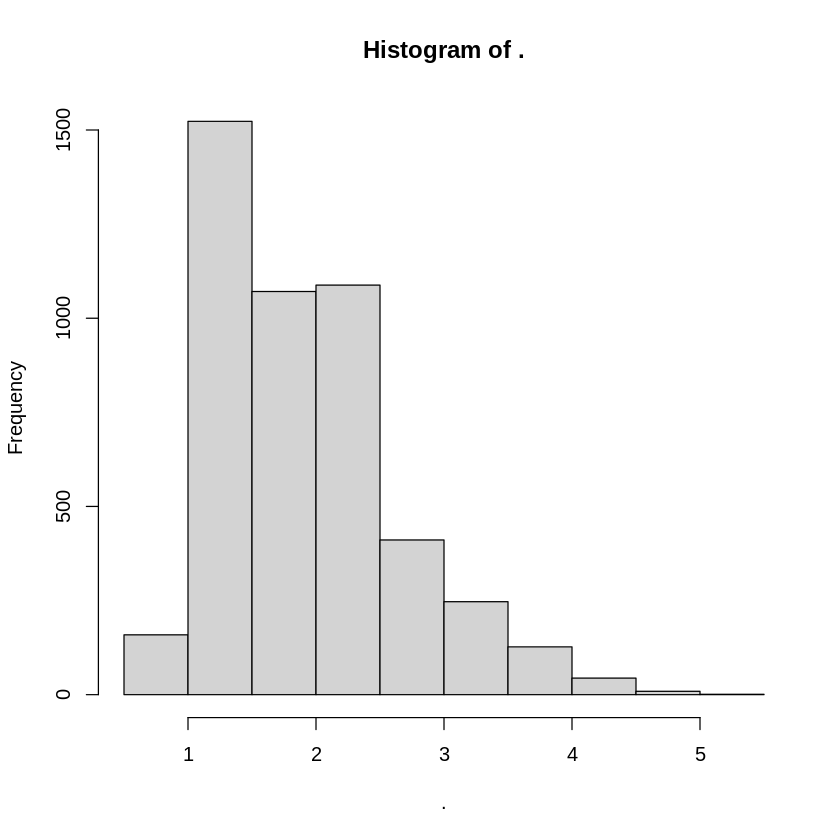

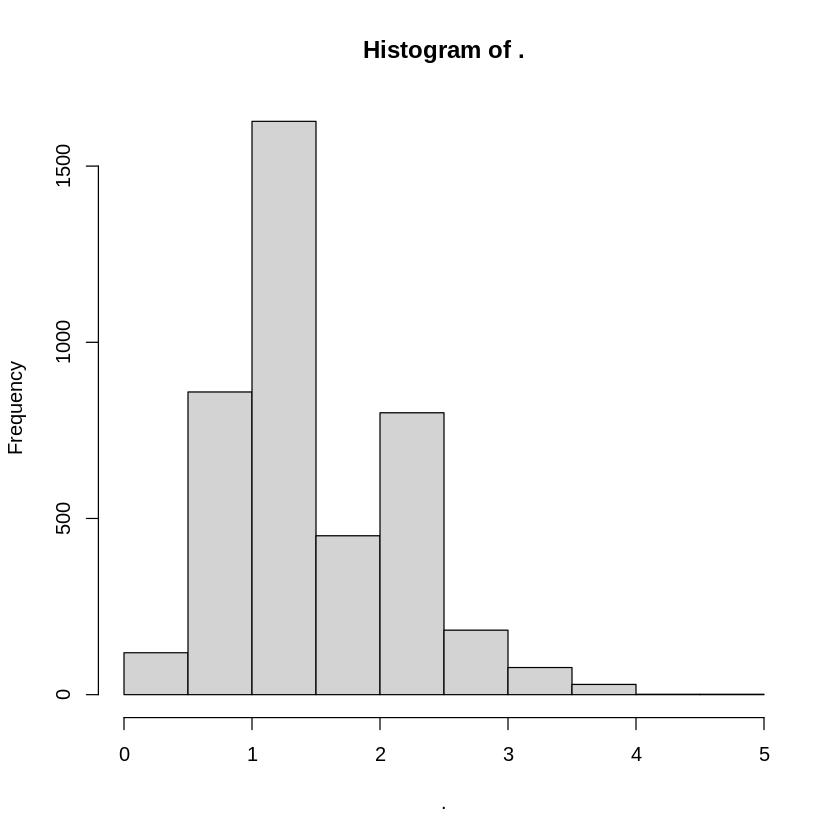

In [98]:
sss %>%
  pull(all_max_value) %>%
  log() %>%
  hist()

sss %>%
  pull(type_max_value) %>%
  log() %>%
  hist()

In [109]:
sss %>%
  select(TotalReads, type_max_value) %>%
  head()

sss %>%
  pull(TotalReads) %>%
  sum()


sss %>%
  pull(type_max_value) %>%
  sum()


TotalReads,type_max_value
<int>,<dbl>
4,0
4,4
13,6
6,4
17,8
14,4


[1] 65933

[1] 24606

In [111]:
q <- 8
m <- 24606
n <- 65933 - 24606
k <- 17


phyper(q, m, n, k, lower.tail = FALSE)

[1] 0.1402872

In [41]:
#?phyper